In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiPolygon
from shapely import affinity
from CPP_Planner import CPP_Planner_Kit
from shapely import ops

In [2]:
all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
# all_land.plot()

<Axes: >

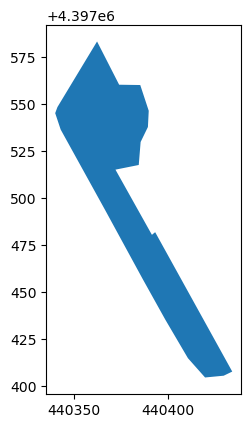

In [3]:
# get single land
single_land = CPP_Planner_Kit.get_single_shp(all_land, 6)
single_land.plot()

In [4]:
def convex_partition(polygon):
    # 将输入多边形转换为Shapely的Polygon对象

    # 初始化凸多边形列表
    convex_polygons = []

    # 创建初始分割线段
    segment = ops.linemerge([polygon.exterior])

    # 迭代进行凸分割
    while segment:
        print(1)
        # 提取分割线段的坐标点
        coords = list(segment.coords)

        # 创建凸多边形
        convex_polygon = Polygon(coords)

        # 将凸多边形添加到列表中
        convex_polygons.append(convex_polygon)

        # 从原多边形中移除已分割的部分
        polygon = polygon.difference(convex_polygon)

        # 创建剩余部分的分割线段
        segment = ops.linemerge([polygon.exterior])

    return convex_polygons
single_polygon = single_land.geometry.iloc[0]
# convex_polygons = convex_partition(single_polygon)

## 将一个多边形，分解为多个凸边形
* 评价：每次尽量分出一个最大的凸边形
* 将当前多边形的非凸边取出
* 遍历每一条非凸边，对集合图形进行分割，得到多个多边形
    * 判断多个多边形：
        * 如果多边形均为凸边形，则结束
        * 如果一个多边形为凸边形，则保存凸边形，而将另外非凸边形放入队列中等待，循环取出

In [5]:
non_convex_polygon = CPP_Planner_Kit.get_non_convex_edges(single_polygon)

Num of convex_hull:  12
Num of Polygon lines:  20
Not on Convex:  11


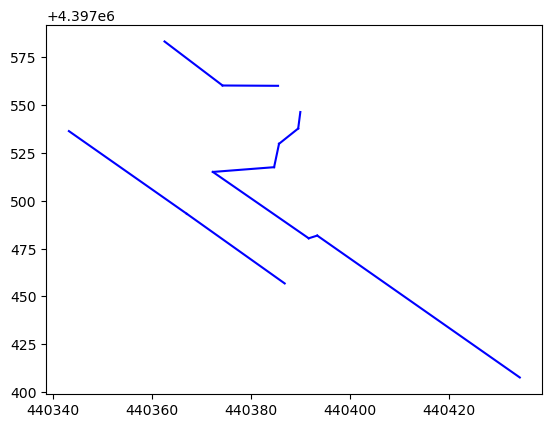

In [6]:
fig, ax = plt.subplots()
for line in non_convex_polygon:
    x, y = line.xy
    ax.plot(x, y, 'b')

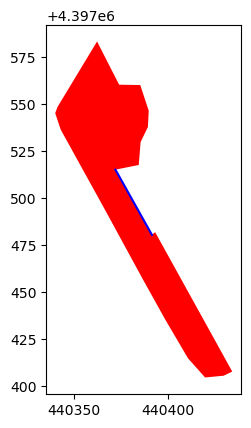

In [43]:
# 模仿一下寻找一条边分割
split_line = non_convex_polygon[8]
# split_line = non_convex_polygon[3]
x, y = split_line.xy
fig, ax = plt.subplots()
single_land.plot(ax=ax, color='r')
ax.plot(x, y, 'b')

Extending lines...
当前分割多边形个数:  3


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


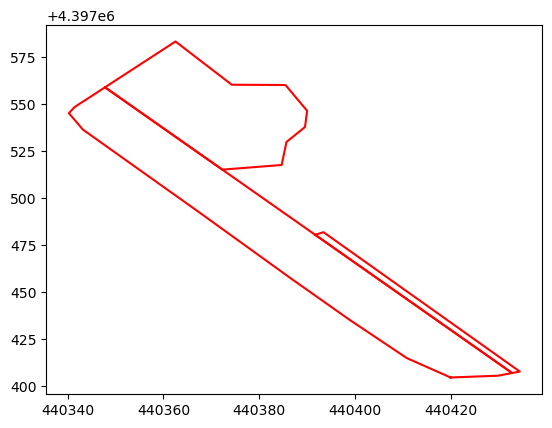

In [44]:
split_polygons = CPP_Planner_Kit.split_polygon_through_1edge(single_polygon, split_line, line_scale_factor=10)
CPP_Planner_Kit.show_geometry_collection(split_polygons)

In [45]:
# 获取 collection 中的每一个几何图形
polygon_list = []
for geom in split_polygons.geoms:
    polygon_list.append(geom)
for polygon in polygon_list:
    print(polygon.area, end=', ')
polygon_list

2553.874023226168, 1523.7280732188456, 167.9561566239413, 

[<POLYGON ((440419.972 4397404.495, 440410.855 4397414.76, 440398.862 4397435...>,
 <POLYGON ((440347.79 4397558.849, 440362.512 4397583.229, 440374.257 4397560...>,
 <POLYGON ((440391.694 4397480.373, 440393.422 4397481.787, 440434.425 439740...>]

In [46]:
polygon_one = polygon_list[0]  # 1 肯定为凹
polygon_convex = polygon_one.convex_hull  # 获取凸包
# 比较凸包和凹边形是否相同，加上 tolerance
# is_same = polygon_convex.equals_exact(polygon_one, tolerance=0.002)
is_same = polygon_one.equals(polygon_convex)
print("equals() same: ", is_same)
# 如果通过面积来判断是否相同呢？例如凸包的面积和凹边形的面积只差不超过10%
if (polygon_convex.area - polygon_one.area) / polygon_one.area < 0.1:
    is_same = True
else:
    is_same = False
print("area() same: ", is_same)

equals() same:  False
area() same:  True


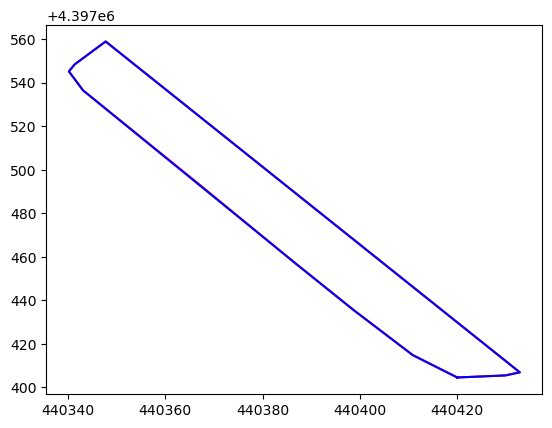

In [47]:
fig, ax = plt.subplots()
x, y = polygon_one.exterior.xy
ax.plot(x, y, 'r')
x, y = polygon_convex.exterior.xy
ax.plot(x, y, 'b')

Num of convex_hull:  10
Num of Polygon lines:  13
Not on Convex:  5


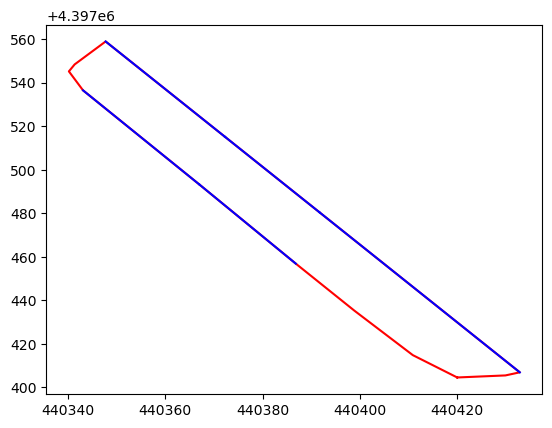

In [48]:
non_conv_edge = CPP_Planner_Kit.get_non_convex_edges(polygon_one)
fig, ax = plt.subplots()
x, y = polygon_one.exterior.xy
ax.plot(x, y, 'r')
for line in non_conv_edge:
    x, y = line.xy
    ax.plot(x, y, 'b')

In [49]:
from CPP_Planner import CPP_Algorithms
# 尝试：用算法试一试分割后的路径规划, split_polygon还原为 geopandas
# gpd_temp_land = gpd.GeoDataFrame(geometry=polygon_list)
paths = []
for polygon in polygon_list:
    temp_gpd = gpd.GeoDataFrame(geometry=[polygon])
    paths.append(CPP_Algorithms.scanline_algorithm_single_no_turn(temp_gpd, 1.4, along_long_edge=True))
# path_temp = CPP_Algorithms.scanline_algorithm_single_no_turn(gpd_temp_land, 1.4, along_long_edge=True)

当前田块角度： 119.22504922436913
根据田块长边开始路径规划...
这次规划完成！
当前田块角度： -60.77473779310664
根据田块长边开始路径规划...
这次规划完成！
当前田块角度： 118.94141830035473
根据田块长边开始路径规划...
这次规划完成！


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


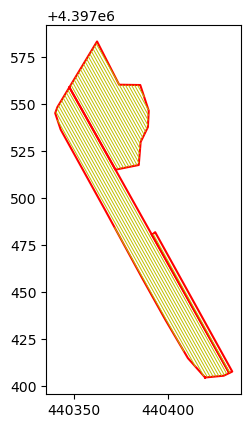

In [50]:
# show land
fig, ax = plt.subplots()
for geom in split_polygons.geoms:
    x, y = geom.exterior.xy
    ax.plot(x, y, 'r')
# path_temp.plot(ax=ax)
for path in paths:
    path.plot(ax=ax, color='y', linewidth=0.7)

In [42]:
# TODO: 写出田块分解算法